In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

In [2]:
torch.cuda.set_device(1)

In [3]:
files = Path("./datasets/CartoonImagenette")

In [4]:
target_classes = [f.name for f in (files/"train").iterdir() if f.is_dir()]
print(f"{len(target_classes)} classes:")
print(target_classes)

28 classes:
['wild_boar', 'hourglass', 'Dobermann', 'zucchini', 'bath_towel', 'Cocker_Spaniels', 'Dalmatian', 'printer', 'eraser', 'cucumber', 'dumbbell', 'cloak', 'Band-Aid', 'barbell', 'Affenpinscher', 'cheeseburger', 'assault_rifle', 'CRT_screen', 'monitor', 'cricket', 'bathtub', 'guacamole', 'microwave_oven', 'photocopier', 'grasshopper', 'American_black_bear', 'bagel', 'dishwasher']


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.downsample = downsample
        self.Conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.Bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.ReLU = nn.ReLU(inplace=True)
        self.Conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.Bn2 = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x):
        identity = x
        features = self.Conv1(x)
        features = self.Bn1(features)
        features = self.ReLU(features)
        features = self.Conv2(features)

        if self.downsample != None:
            identity = self.downsample(identity)

        out = self.Bn2(features)
        out += identity

        return self.ReLU(out)

In [6]:
class DoloresResNet(nn.Module):
    def __init__(self, channels=3, targets=28):
        super().__init__()
        self.Stem = nn.Sequential(nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=2, padding=2),
                                   nn.BatchNorm2d(num_features=32),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=5, stride=2, padding=2))
        
        self.Layer1 = nn.Sequential(ResidualBlock(in_channels=32, out_channels=32, stride=1),
                                    ResidualBlock(in_channels=32, out_channels=32, stride=1))
        
        self.Layer2 = nn.Sequential(ResidualBlock(in_channels=32, out_channels=64, stride=2, 
                                    downsample=nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2, bias=False),
                                                            nn.BatchNorm2d(num_features=64))),
                                    ResidualBlock(in_channels=64, out_channels=64, stride=1))
        
        self.Layer3 = nn.Sequential(ResidualBlock(in_channels=64, out_channels=128, stride=2, 
                                    downsample=nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2, bias=False),
                                                            nn.BatchNorm2d(num_features=128))),
                                    ResidualBlock(in_channels=128, out_channels=128, stride=1))
        
        self.Layer4 = nn.Sequential(ResidualBlock(in_channels=128, out_channels=256, stride=2, 
                                    downsample=nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2, bias=False),
                                                            nn.BatchNorm2d(num_features=256))),
                                    ResidualBlock(in_channels=256, out_channels=256, stride=1))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Linear(in_features=256, out_features=targets))
        
    def forward(self, x):
        features = self.Stem(x)
        features = self.Layer1(features)
        features = self.Layer2(features)
        features = self.Layer3(features)
        features = self.Layer4(features)
        out = self.classifier(features)

        return out

In [7]:
model = DoloresResNet(channels=3, targets=28)

fake_image = torch.randn(1, 3, 256, 256)

output = model(fake_image)

print(f"Tamaño de entrada: {fake_image.shape}")
print(f"Tamaño de salida:  {output.shape}")

Tamaño de entrada: torch.Size([1, 3, 256, 256])
Tamaño de salida:  torch.Size([1, 28])


In [8]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = Path(root_dir)
        self.classes = sorted([p.name for p in self.root_dir.iterdir() 
                               if p.is_dir() and not p.name.startswith('.')])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = [p for p in self.root_dir.rglob("*.jpg") 
                            if ".ipynb_checkpoints" not in p.parts]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        class_name = img_path.parent.name

        if class_name not in self.class_to_idx:
            # Si cae aquí, es porque encontró una carpeta rara.
            # Asignamos una clase 'dummy' o lanzamos un error más descriptivo
            raise ValueError(f"La carpeta '{class_name}' no está en la lista de clases permitidas: {self.classes}")
        
        class_idx = self.class_to_idx[class_name]
        
        image = Image.open(img_path).convert('RGB')
        image = image.resize((256, 256))
        image = TF.to_tensor(image)
        return image, class_idx

In [9]:
train_route =  (files/"train") 
valid_route = (files/"valid")  

train_ds = CustomDataset(root_dir=train_route)
valid_ds = CustomDataset(root_dir=valid_route)

print(f"Train: {len(train_ds)} Images | Classes: {train_ds.class_to_idx}")
print(f"Valid: {len(valid_ds)} Images")

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False) 

Train: 35750 Images | Classes: {'Affenpinscher': 0, 'American_black_bear': 1, 'Band-Aid': 2, 'CRT_screen': 3, 'Cocker_Spaniels': 4, 'Dalmatian': 5, 'Dobermann': 6, 'assault_rifle': 7, 'bagel': 8, 'barbell': 9, 'bath_towel': 10, 'bathtub': 11, 'cheeseburger': 12, 'cloak': 13, 'cricket': 14, 'cucumber': 15, 'dishwasher': 16, 'dumbbell': 17, 'eraser': 18, 'grasshopper': 19, 'guacamole': 20, 'hourglass': 21, 'microwave_oven': 22, 'monitor': 23, 'photocopier': 24, 'printer': 25, 'wild_boar': 26, 'zucchini': 27}
Valid: 1400 Images


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device:{device}")

Device:cuda


In [11]:
model = DoloresResNet(channels=3, targets=28).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

start_manual = time.time()

EPOCHS = 12


for epoch in range(EPOCHS):
    print(f"\n--- Época {epoch+1}/{EPOCHS} ---")
    
    # FASE DE ENTRENAMIENTO
    model.train() # Pone la red en modo "aprender" (activa dropout, batchnorm, etc)
    train_loss = 0.0
    
    for images, labels in train_dl:
        # Mover datos a GPU/CPU
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward (Predicción)
        outputs = model(images)
        
        # 2. Calcular el error
        loss = criterion(outputs, labels)
        
        # 3. Backward (Calcular gradientes - la culpa)
        optimizer.zero_grad() # Limpiar culpas anteriores
        loss.backward()       # Retropropagar el error
        
        # 4. Step (Ajustar pesos)
        optimizer.step()
        
        train_loss += loss.item()
    
    # Promedio del error en entrenamiento
    avg_train_loss = train_loss / len(train_dl)
    print(f"Entrenamiento Loss: {avg_train_loss:.4f}")

    # FASE DE VALIDACIÓN 
    model.eval() # Pone la red en modo "examen" (congela batchnorm)
    valid_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # No calculamos gradientes aquí (ahorra memoria y tiempo)
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            
            # Calcular precisión (Accuracy)
            _, predicted = torch.max(outputs.data, 1) # ¿Cuál es la clase con mayor probabilidad?
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_valid_loss = valid_loss / len(valid_dl)
    acc_manual = 100 * correct / total
    
    scheduler.step(avg_valid_loss) # Actualizar el learning rate

    current_lr = optimizer.param_groups[0]['lr']

    print(f"Validación Loss:    {avg_valid_loss:.4f}")
    print(f"Precisión (Acc):    {acc_manual:.2f}%")

duration_manual = time.time() - start_manual


--- Época 1/12 ---


Entrenamiento Loss: 2.5437
Validación Loss:    2.3202
Precisión (Acc):    27.43%

--- Época 2/12 ---
Entrenamiento Loss: 2.0533
Validación Loss:    2.4917
Precisión (Acc):    26.93%

--- Época 3/12 ---
Entrenamiento Loss: 1.7771
Validación Loss:    2.6492
Precisión (Acc):    26.00%

--- Época 4/12 ---
Entrenamiento Loss: 1.5785
Validación Loss:    1.8226
Precisión (Acc):    42.21%

--- Época 5/12 ---
Entrenamiento Loss: 1.4148
Validación Loss:    1.9091
Precisión (Acc):    42.86%

--- Época 6/12 ---
Entrenamiento Loss: 1.2782
Validación Loss:    1.5671
Precisión (Acc):    49.43%

--- Época 7/12 ---
Entrenamiento Loss: 1.1526
Validación Loss:    1.5077
Precisión (Acc):    52.86%

--- Época 8/12 ---
Entrenamiento Loss: 1.0263
Validación Loss:    1.5981
Precisión (Acc):    50.57%

--- Época 9/12 ---
Entrenamiento Loss: 0.8932
Validación Loss:    1.7765
Precisión (Acc):    48.86%

--- Época 10/12 ---
Entrenamiento Loss: 0.7760
Validación Loss:    1.4415
Precisión (Acc):    54.64%

--- Époc

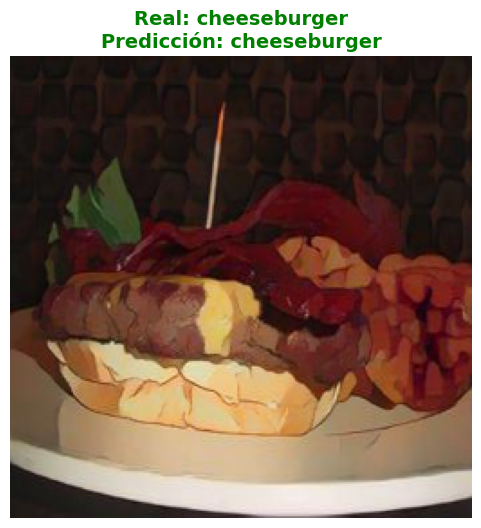

Confianza del modelo: 2.09


In [12]:
# 1. Asegurarnos de que el modelo esté en modo evaluación (apagamos dropout, etc.)
model.eval()

# 2. Elegir una imagen al azar del Dataset de Validación
idx = random.randint(0, len(valid_ds)-1)
image_tensor, label_idx = valid_ds[idx]

# 3. Preparar la imagen para la red
# La red espera un lote (batch), así que añadimos una dimensión extra: [1, 3, 256, 256]
input_tensor = image_tensor.unsqueeze(0).to(device)

# 4. Predicción
with torch.no_grad():
    output = model(input_tensor)
    # torch.max nos devuelve: (probabilidad_mas_alta, indice_ganador)
    confidence, predicted_idx = torch.max(output, 1)

# 5. Traducir números a nombres (Decodificar)
real_name = valid_ds.classes[label_idx]
pred_name = valid_ds.classes[predicted_idx.item()]

# 6. Visualizar
# La imagen es un Tensor (C, H, W), Matplotlib necesita (H, W, C) y estar en CPU
img_display = image_tensor.permute(1, 2, 0).cpu()

plt.figure(figsize=(6,6))
plt.imshow(img_display)

# Ponemos el título verde si acertó, rojo si falló
color = "green" if real_name == pred_name else "red"
plt.title(f"Real: {real_name}\nPredicción: {pred_name}", color=color, fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Confianza del modelo: {confidence.item():.2f}")

In [13]:
file_name = 'DoloresResNet_Entregable.pth'
torch.save(model.state_dict(), file_name)

# Fastai Implementation

In [14]:
from fastai.vision.all import *

epoch,train_loss,valid_loss,accuracy,time
0,2.325948,2.501842,0.271429,00:45
1,2.041098,3.649578,0.156429,00:45
2,1.863454,2.361354,0.287143,00:45
3,1.617817,1.877042,0.430714,00:45
4,1.469388,1.627934,0.487857,00:45
5,1.350935,1.466253,0.517857,00:45
6,1.222872,1.334734,0.572857,00:46
7,1.108903,1.266769,0.580000,00:46
8,1.011654,1.128523,0.602857,00:46
9,0.916794,1.096212,0.632857,00:45


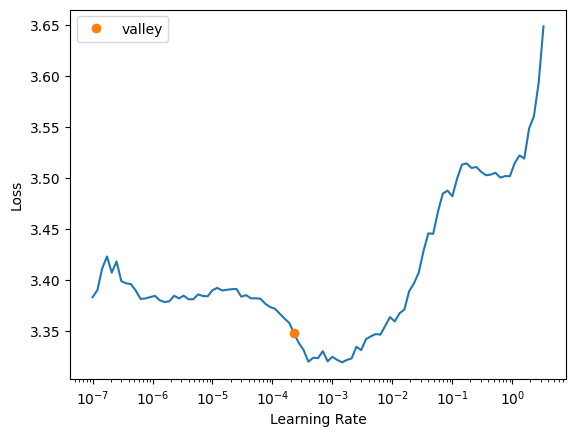

In [15]:
dls_fastai = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(256),
    batch_tfms=aug_transforms()
).dataloaders(files, bs=32)

learn = Learner(dls_fastai, DoloresResNet(targets=28), metrics=accuracy)
learn.lr_find()

start_fastai = time.time()
learn.fit_one_cycle(12, 1e-3)
duration_fastai = time.time() - start_fastai

final_metrics = learn.recorder.log
loss_fastai = final_metrics[2]
acc_fastai = final_metrics[3] * 100

In [16]:
def format_time(seconds):
    m, s = divmod(seconds, 60)
    return f"{int(m)}m {int(s)}s"

TABLA COMPARATIVA DE RESULTADOS


,Métrica,PyTorch Manual,Fastai (One Cycle)
0,Precisión (Accuracy),52.86%,64.14%
1,Loss Final (Validación),1.7564,1.0584
2,Tiempo de Ejecución,21m 41s,9m 10s


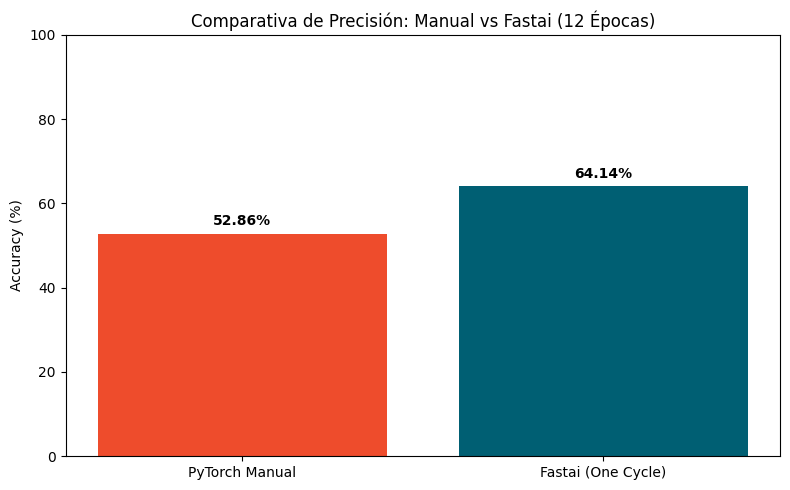

In [17]:
# 1. Recolectamos los datos (usando las nuevas variables sin conflictos)
data = {
    'Métrica': ['Precisión (Accuracy)', 'Loss Final (Validación)', 'Tiempo de Ejecución'],
    'PyTorch Manual': [
        f"{acc_manual:.2f}%", 
        f"{avg_valid_loss:.4f}", 
        format_time(duration_manual)
    ], 
    'Fastai (One Cycle)': [
        f"{acc_fastai:.2f}%", 
        f"{loss_fastai:.4f}", 
        format_time(duration_fastai)
    ]
}

df_comparativa = pd.DataFrame(data)

print("TABLA COMPARATIVA DE RESULTADOS")
display(df_comparativa)

# 2. Gráfica de barras
plt.figure(figsize=(8, 5))
plt.bar(['PyTorch Manual', 'Fastai (One Cycle)'], [acc_manual, acc_fastai], color=['#ee4c2c', '#005f73'])
plt.ylabel('Accuracy (%)')
plt.title('Comparativa de Precisión: Manual vs Fastai (12 Épocas)')
plt.ylim(0, 100)

for i, v in enumerate([acc_manual, acc_fastai]):
    plt.text(i, v + 2, f"{v:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()